In [143]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import matplotlib.image as mpimg
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras import metrics
#sklearn helpers
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

In [ ]:
files = os.listdir("../input/breast-histopathology-images/")
print(len(files))

In [ ]:
ORIG_PATH = "../input/breast-histopathology-images/IDC_regular_ps50_idx5/"
class_0_path = []
class_1_path = []
for folder in os.listdir(ORIG_PATH):
    class_0_folder = ORIG_PATH+folder+'/0/'
    class_1_folder = ORIG_PATH+folder+'/1/'
    for f in os.listdir(class_0_folder):
        class_0_path.append(class_0_folder+f)
    for f in os.listdir(class_1_folder):
        class_1_path.append(class_1_folder+f)

In [ ]:
print("Number of patches with no cancer tissue = ", len(class_0_path))
print("Number of patches with cancer tissue = ", len(class_1_path))

In [ ]:
total = len(class_0_path) + len(class_1_path)
weight_0 = (1 / len(class_0_path))*(total)/2.0 
weight_1 = (1 / len(class_1_path))*(total)/2.0

class_weight = {0: weight_0, 1: weight_1}

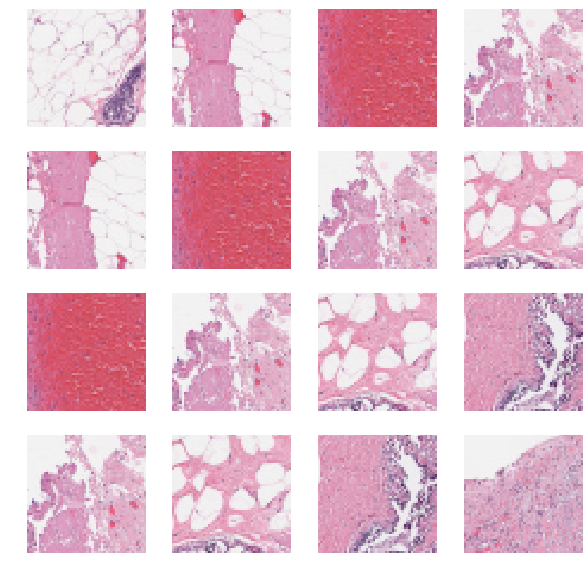

In [144]:
#Let's look at some patches with no IDC
fig, ax = plt.subplots(nrows = 4, ncols = 4, figsize  = (10,10))
for i in range(4):
    for j in range(4):
        img = mpimg.imread(class_0_path[i+j])
        ax[i,j].imshow(img)
        ax[i,j].axis("OFF")

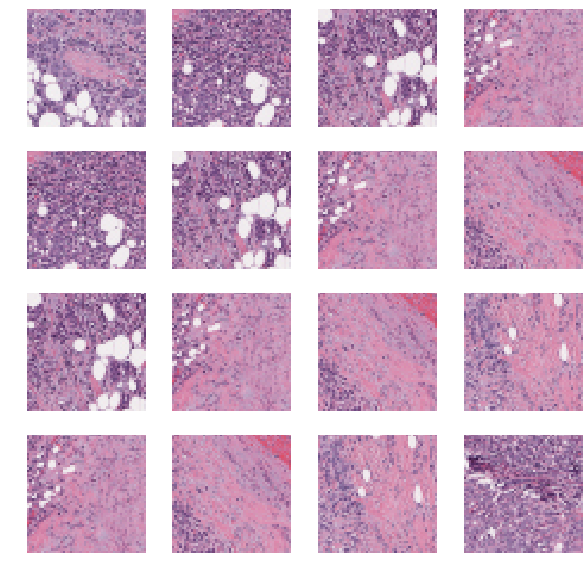

In [145]:
#Let's look at some patches with IDC
fig, ax = plt.subplots(nrows = 4, ncols = 4, figsize  = (10,10))
for i in range(4):
    for j in range(4):
        img = mpimg.imread(class_1_path[i+j])
        ax[i,j].imshow(img)
        ax[i,j].axis("OFF")

We note that the patches with IDC appear to have more clumpy purple regions

In [ ]:
# derive the training, validation, and testing directories
working_path = "/kaggle/working/"

TRAIN_PATH = working_path +"train"
VALID_PATH = working_path +"valid"
TEST_PATH = working_path +"test"
paths = {"train": TRAIN_PATH, 
        "valid": VALID_PATH, 
        "test": TEST_PATH}
for key, value in paths.items():
    if not os.path.exists(value):
            os.mkdir(value)
    for CLASS in [0,1]:
        label_path = os.path.sep.join([value, str(CLASS)])
        if not os.path.exists(label_path):
            os.mkdir(label_path)

N0, N1 = len(class_0_path), len(class_1_path)
TRAIN_SPLIT_POINT_0 = int(0.8*N0)
VALID_SPLIT_POINT_0 = int(0.9*N0)
TRAIN_SPLIT_POINT_1 = int(0.8*N1)
VALID_SPLIT_POINT_1 = int(0.9*N1)

In [ ]:
print(TRAIN_SPLIT_POINT_0, VALID_SPLIT_POINT_0, TRAIN_SPLIT_POINT_1, VALID_SPLIT_POINT_1)

In [ ]:
cnt = 0
for img in class_0_path[0:TRAIN_SPLIT_POINT_0]:
    new_path = os.path.sep.join([paths["train"]+"/0", str(cnt)+".png"])
    shutil.copy2(img, new_path)
    cnt += 1
    
for img in class_0_path[TRAIN_SPLIT_POINT_0:VALID_SPLIT_POINT_0]:
    new_path = os.path.sep.join([paths["valid"]+"/0", str(cnt)+".png"])
    shutil.copy2(img, new_path)
    cnt += 1

for img in class_0_path[VALID_SPLIT_POINT_0:]:
    new_path = os.path.sep.join([paths["test"]+"/0", str(cnt)+".png"])
    shutil.copy2(img, new_path)
    cnt += 1

In [ ]:
cnt = 0
for img in class_1_path[0:TRAIN_SPLIT_POINT_1]:
    new_path = os.path.sep.join([paths["train"]+"/1", str(cnt)+".png"])
    shutil.copy2(img, new_path)
    cnt += 1
    
for img in class_1_path[TRAIN_SPLIT_POINT_1:VALID_SPLIT_POINT_1]:
    new_path = os.path.sep.join([paths["valid"]+"/1", str(cnt)+".png"])
    shutil.copy2(img, new_path)
    cnt += 1

for img in class_1_path[VALID_SPLIT_POINT_1:]:
    new_path = os.path.sep.join([paths["test"]+"/1", str(cnt)+".png"])
    shutil.copy2(img, new_path)
    cnt += 1

In [ ]:
def build_model(retrain = False):
    
    base_model = InceptionV3(weights="imagenet", include_top=False, input_shape = (150, 150, 3))
    if retrain == False:
        for layer in base_model.layers:
            layer.trainable = False
    else:
        for layer in base_model.layers:
            layer.trainable = True
    x = base_model.output
    x = layers.GlobalMaxPooling2D()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    # Configure and compile the model
    model = Model(base_model.input, x)
    
    return model

In [ ]:
train_generator = ImageDataGenerator(
    rescale=1 / 255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest")

valid_generator = ImageDataGenerator(rescale=1 / 255.0)

In [ ]:
BS = 32
LR = 0.0001

In [ ]:
# initialize the training generator
trainGen = train_generator.flow_from_directory(
    paths["train"],
    target_size=(150, 150),
    class_mode="binary",
    color_mode="rgb",
    shuffle=True,
    batch_size=BS)
 
# initialize the validation generator
valGen = valid_generator.flow_from_directory(
    paths["valid"],
    target_size=(150, 150),
    class_mode="binary",
    color_mode="rgb",
    shuffle=False,
    batch_size=BS)

In [ ]:
# EARLY STOPPING

early_stopping = EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

# MODEL EVALUATIONS

model_eval_metrics = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc')]

In [ ]:
optimizer = Adam(lr=LR, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)

In [ ]:
model = build_model(retrain=True)
model.summary()
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizer,
              metrics = model_eval_metrics)

In [ ]:
NEPOCHS = 10
history = model.fit_generator(trainGen,
                              epochs = NEPOCHS, 
                              validation_data = valGen,
                              class_weight = class_weight,
                              callbacks = [early_stopping],
                              verbose = 1)

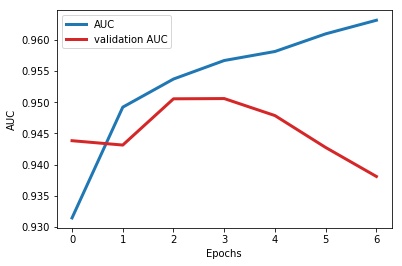

In [93]:
plt.plot(history.history["auc"], color = "C0", lw = 3, label = "AUC")
plt.plot(history.history["val_auc"], color = "C3", lw  = 3, label = "validation AUC")
plt.ylabel("AUC")
plt.xlabel("Epochs")
plt.legend()

In [94]:
test_generator = valid_generator.flow_from_directory(
        paths["test"],
        target_size=(150, 150),
        batch_size=BS,
        class_mode=None,  # only data, no labels
        shuffle=False)
true_labels = test_generator.labels

Found 27753 images belonging to 2 classes.


In [95]:
test_probs = model.predict_generator(test_generator)

In [97]:
fpr, tpr, thresholds = roc_curve(true_labels, test_probs)

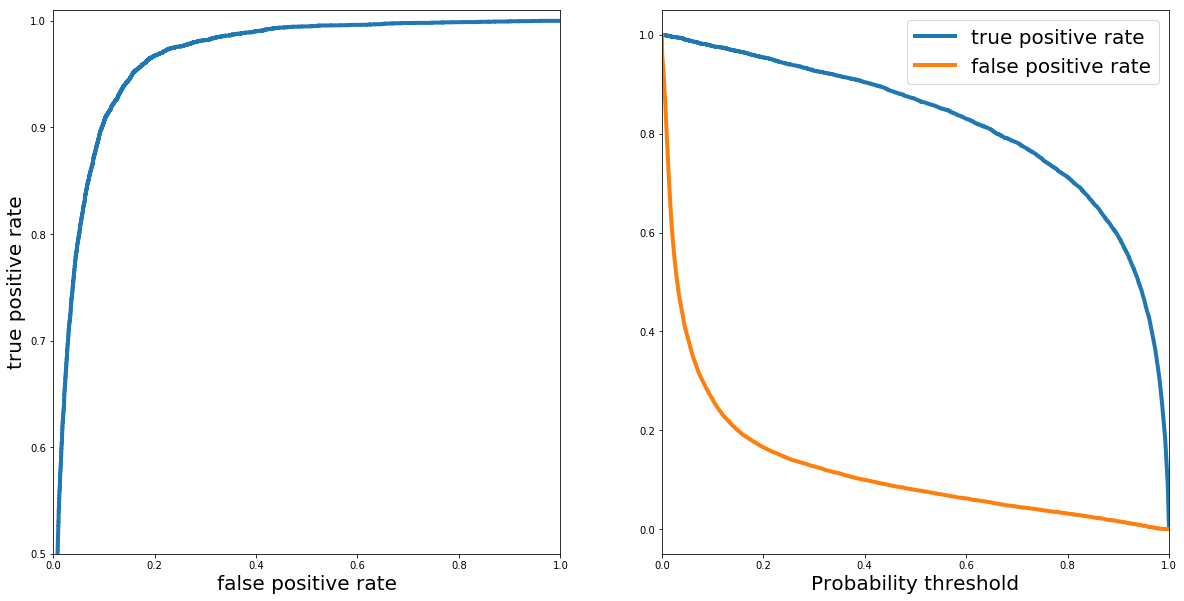

In [103]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,10))
ax[0].plot(fpr, tpr, lw = 4)
ax[0].set_xlabel('false positive rate', fontsize = 20)
ax[0].set_ylabel('true positive rate', fontsize = 20)
ax[0].set_xlim(0.0, 1)
ax[0].set_ylim(0.5, 1.01)
ax[1].plot(thresholds, tpr, lw = 4, label = "true positive rate")
ax[1].plot(thresholds, fpr, lw = 4, label = "false positive rate")
ax[1].set_xlabel("Probability threshold", fontsize = 20)
ax[1].set_xlim(0,1)
#ax[1].set_yscale("log")
ax[1].legend(fontsize = 20)

In [104]:
test_pred = np.zeros_like(test_probs)
test_pred[test_probs > 0.5] = 1

Text(0.5, 1.0, 'Confusion matrix')

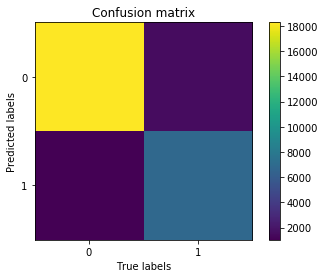

In [106]:
confusion = confusion_matrix(true_labels, test_pred)
plt.imshow(confusion)
plt.ylabel("Predicted labels")
plt.xlabel("True labels")
plt.colorbar()
plt.xticks([0, 1])
plt.yticks([0,1])
plt.title("Confusion matrix")

In [107]:
report = classification_report(true_labels, 
                      test_pred, 
                      labels = [0,1], 
                      target_names = ["no IDC", "IDC"])
print(report)

              precision    recall  f1-score   support

      no IDC       0.95      0.92      0.93     19874
         IDC       0.81      0.87      0.84      7879

    accuracy                           0.91     27753
   macro avg       0.88      0.90      0.89     27753
weighted avg       0.91      0.91      0.91     27753



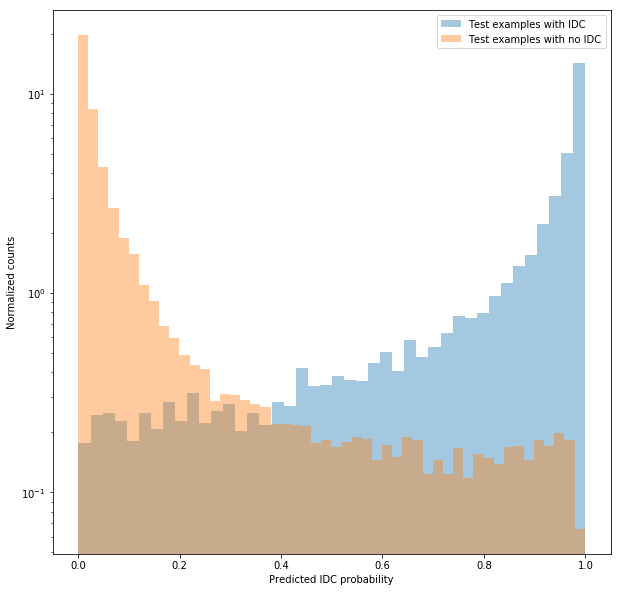

In [90]:
plt.figure(figsize = (10,10))
sns.distplot(test_probs[true_labels == 1], norm_hist=True, kde = False, label = "Test examples with IDC")
sns.distplot(test_probs[true_labels == 0], norm_hist=True, kde = False, label = "Test examples with no IDC")
plt.yscale("log")
plt.xlabel("Predicted IDC probability", fontsize = 10)
plt.ylabel("Normalized counts", fontsize = 10)
plt.legend(fontsize = 10, loc = "best")

In [112]:
test_IDC_path = paths["test"]+"/1"
test_IDC_examples = os.listdir(test_IDC_path)
def preprocess(example_fname):
    """
    this function preprocesses the image 
    such that it can be fed to our CNN model
    """    
    im = cv2.imread(example_fname)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (150, 150))
    im = im / 255.
    
    return im

In [127]:
def vizualize_activations(img):
    '''
    It shows the output of different convolution and pooling 
    layers in the CNN

    input: image index in the test set 
    '''
    print("Vizualising the output of Convolution layers and Pooling layer for test example")
    layer_outputs = [layer.output for layer in model.layers][0:]
    activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)
    feature_maps = activation_model.predict(img)
    nlayers = len(feature_maps)
    for layer_index in range(1):
      layer_feature_maps = feature_maps[layer_index][0]
      layer_depth = layer_feature_maps.shape[-1]
      fig, ax = plt.subplots(nrows = 1, ncols = layer_depth)
      if np.mod(layer_index ,2) == 0:
        ax[0].set_ylabel("CONV2D")
      else:
        ax[0].set_ylabel("Average Pooling")  
      for i in range(layer_depth):
        ax[i].imshow(layer_feature_maps[:,:,i])
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    
    return None

In [140]:
def vizualize_example_activation(test_index):
    
    #proprocess a text example with index = test_index
    test_example = preprocess(test_IDC_path+"/"+test_IDC_examples[test_index])
    #calculate the cancer probability
    IDC_prob = model.predict(np.expand_dims(test_example, axis=0))
    #show the picture of the tissue itself
    plt.imshow(test_example)
    plt.title("Probability of IDC is ="+str(round(IDC_prob[0][0],3)))
    plt.axis("OFF")
    #show the activation maps
    vizualize_activations(np.expand_dims(test_example, axis=0))
    
    return None

Vizualising the output of Convolution layers and Pooling layer for test example


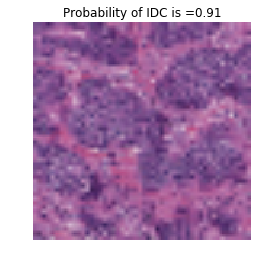

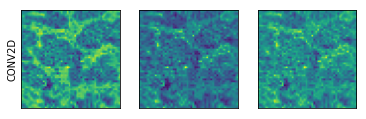

In [142]:
vizualize_example_activation(400)